In this notebook we are going to calculate the adiabatic flame temperature of a combustion reaction. As always, the first thing to do is load some dependencies. For this notebook, I will need numpy, pyplot from matplotlib, and integrate from scipy.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.optimize import fsolve


For an adiabatic flame temperature, all of the heat produced by a reaction goes into heating the gases that are produced by the reaction. There are a few ways to calculate adiabatic flame temperature, but the easiest, given what we've talked about so far in class, is to use the reaction enthalpy and constant pressure heat capacity of the gases to find the change in temperature. This is complicated, to some degree, that flame temperatures are pretty hot, and we've seen that the heat capacity of gases can depend on temperature. Luckily, we've already seen how to calculate heat capacity at different temperatures using the Shomate equation.

As a reminder, the Shomate equation is $C_p = a_1 + a_2 \frac{T}{1000} + a_3 (\frac{T}{1000})^{2} + a_4 (\frac{T}{1000})^{3} + a_5 (\frac{T}{1000})^{-2}$ and the coefficients are tabulated a number of places, such as the [NIST chemistry webbook](https://webbook.nist.gov/chemistry/). For example, the coefficients for [gaseous oxygen](https://webbook.nist.gov/cgi/cbook.cgi?ID=C7782447&Type=JANAFG&Plot=on) are $a_1 = 31.32234, a_2 = -20.23531, a_3 = 57.86644, a_4 = -36.50624, a_5 = -0.007374$. In the box below, write a function that takes six inputs, one for each coefficient and the temperature in Kelvin, and returns the constant pressure heat capacity in $\frac{J}{K mol}$

In [2]:
def heatCap_P(a1, a2, a3, a4, a5, temp):
    tempNorm = temp/1000
    return (a1 + a2*tempNorm + a3*(tempNorm**2) + a4*(tempNorm**3) + a5*(tempNorm**(-2)))



Now that you have a function that calculates the heat capacity of a gas, we need a function that will calculate and return the enthalpy necessary to heat one mole of CO$_2$ gas. The reason for this is two-fold. One, we ultimately need to find the temperature where $\Delta$H$_{reaction}$ - $\Delta$H$_{heating}$ is zero, and so we need to calculate the $\Delta$H$_{heating}$ for gases that are present, such as CO$_2$. Second, the Shomate equation for CO$_2$ has two temperature ranges, so having a function with conditionals (i.e. if-else statements) will let us take care of these two ranges in a fairly straightforward manner.

To accomplish this, I've written a function called heatCO2 that takes two inputs, an initial temperature in Kelvin and a final temperature in Kelvin, and returns the amount of heat it takes to heat CO$_2$ from the inital temperature to the final temperature. As you can see from the [NIST webbook page for CO$_2$](https://webbook.nist.gov/cgi/cbook.cgi?Name=carbon+dioxide&Units=SI&cTG=on#), the Shomate equation has two sets of coefficients, one from 298 K to 1200 K and another above 1200 K. To account for these two regions, I'm going to assume that our inital temperature is less than 1200 K, and use an if-else statement to determine what to do based on the final temperature. If the final temperature is less than or equal to 1200 K I will integrate the first form of the Shomate equation from the initial temperature to the final temperature to find the total heat necessary. If the final temperature is greater than 1200 K I will first integrate the low temperature form of the Shomate equation from the initial temperature to 1200 K, then integrate the high temperature form from 1200 K to the final temperature and add both heats together. I will then return the total heat necessary to heat CO$_2$ from the initial temperature to the final temperature.

In [3]:
def heatCO2(initTemp, finalTemp):
    if finalTemp <= 1200:
        intResultQ, intErrorQ = integrate.quad(lambda T: heatCap_P(24.99735, 55.18696, -33.69137, 7.948387, -0.136638, T), initTemp, finalTemp)
    else:
        intResultLowT, intErrorLowT = integrate.quad(lambda T: heatCap_P(24.99735, 55.18696, -33.69137, 7.948387, -0.136638, T), initTemp, 1200)
        intResultHighT, intErrorHighT = integrate.quad(lambda T: heatCap_P(58.16639, 2.720074, -0.492289, 0.038844, -6.447293, T), 1200, finalTemp)
        intResultQ = intResultLowT + intResultHighT
    return intResultQ
  

Now it's your turn. In addition to CO$_2$, we will also want functions for N$_2$ and H$_2$O, both of which have more than one form of the Shomate equation. Write two functions, one called heatN2 and the other called heatH2O, that calculate the heat necessary to heat one mole N$_2$ or H$_2$O from an initial temperature to a final temperature, using my heatCO2 function as a model. Because N$_2$ has [three temperature ranges for the Shomate equation](https://webbook.nist.gov/cgi/cbook.cgi?Name=nitrogen&Units=SI&cTG=on#), you'll need to use an if-elif-else statement, rather than just an if-else statement! Also, even though the low temperature version of the [Shomate equation for water vapor](https://webbook.nist.gov/cgi/cbook.cgi?Name=water&Units=SI&cTG=on) only goes down to 500 K, you can assume it is valid all the way down to room temperature (298 K).

I like to check my functions to make sure they seem to be working correctly, and a good way to do that is to graph the functions over some range. In the box below, I've written code to graph the three heating functions from 300 to 5500 K, with CO$_2$ in red, H$_2$O in green, and N$_2$ in blue. Run the code to graph your functions. They should be curves that increase in a smooth fashion.

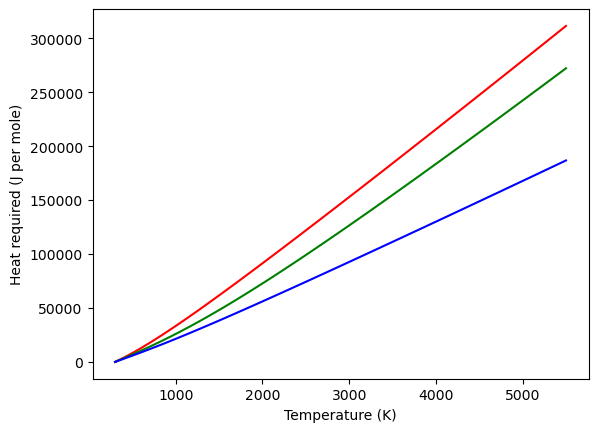

In [13]:
xrange = np.linspace(300,5500)
carbondioxideQ = []
waterQ = []
nitrogenQ = []

for value in xrange:
    carbondioxideQ += [heatCO2(298,value)]
    waterQ += [heatH2O(298,value)]
    nitrogenQ += [heatN2(298,value)]


plt.plot(xrange, carbondioxideQ, 'r')
plt.plot(xrange, waterQ, 'g')
plt.plot(xrange, nitrogenQ, 'b')

plt.xlabel("Temperature (K)")
plt.ylabel("Heat required (J per mole)")
plt.show()

Now that we can calculate how much heat it takes to raise the temperature of a gas, we can use these functions to find the adiabatic flame temperature. To do this, though, we need to take an iterative approach, because simple algebra won't let us find the final temperature for heating a gas because it is one of the limits of integration, not a variable we can solve for. There are a few ways to solve this kind of problem, but they almost all involve essentially the same process, where you guess what the final temperature is, calculate how much heat it took to get to that temperature and then subtract it from how much heat the reaction produced. This left over amount of heat will tell us if we need to increase or decrease the final temperature, so then we make another guess based on this information, and repeat until the difference between energy used to heat the gas and reaction enthalpy is equal to zero. Because this will be something solved iteratively, it's best to use a function to calculate the difference between the reaction enthalpy and the heat used to heat up the gas. To that end, I've written a function below, called excessEnthalpyCO2 that takes two temperatures and a reaction enthalpy, uses the temperatures to calculate how much heat is required to heat CO$_2$ from the initial temperature to the final temperature, and then returns the difference between the reaction enthalpy and the CO$_2$ heating enthalpy. There are three items you should note about this function. First, notice that I have written the function so that the final temperature is the first function variable. This will be important later when we need to use an iterative method to solve for this final temperature. Second, notice that I'm taking the difference between the reaction enthalpy and the gas heating enthalpy. For this to work, we will need to pass the reaction enthalpy to the function as a positive number. Finally, the Shomate equation calculates heat capacity in joules per mole per kelvin, whereas reaction enthalpies are usually in kJ per mole, so we need to be careful about our units. The way I've written this function the reaction enthalpy will need to be input in joules per mole, not kJ per mole.

In [41]:
def excessEnthalpyCO2(finalTemp, initTemp, rxnEnthalpy):
    heatEnthalpy = heatCO2(initTemp, finalTemp)
    return rxnEnthalpy - heatEnthalpy
    

Now that I've written my excessEnthalpyCO2 function, let's test it out on a simple case. Consider the combustion of graphite in pure oxygen. The balance reaction for this is C(graphite) + O$_2$ $\rightarrow$ CO$_2$, and the enthalpy for this reaction is $\Delta$H = -393.5 kJ. So, let's use the excessEnthalpyCO2 function to see how much heat is left over after I heat CO$_2$ from room temperature (298 K) to 5000 K.

In [42]:
excessHeat = excessEnthalpyCO2(5000, 298, 393500)

print('Combusting 1 mole of graphite in pure oxygen and heating the product carbon dioxide from 298 to 5000 K results in {:.2f} joules of heat remaining'.format(excessHeat))


Combusting 1 mole of graphite in pure oxygen and heating the product carbon dioxide from 298 to 5000 K results in 114204.88 joules of heat remaining


Now that we have the excessEnthalpyCO2 function defined and working we can finally do an iterative process to find our adiabatic flame temperature. One of the nice things about python is that it has a number of libraries that where someone else has written a function to do something useful. In this case, a group of people have written a library called SciPy with a set of optimization functions, and we're going to use one of those functions. In particular, we're going to use the fsolve() function to find the  temperature where our excessEnthalpyCO2 function is zero. In other words, the final temperature we need to heat CO2 to so that all of the reaction enthalpy goes into heating a mole of CO$_2$ gas. I've done this in the box, below. You'll notice that the fsolve() function has three arguments. The first is the name of the function we're trying to find the zero for, the second is my best guess for the final temperature, and the third is a group of numbers that are the other arguments for my excessEnthalpyCO2 function. You'll also notice that I have put a [0] after the fsolve() function. The reason for this is that fsolve() is written to return an array of all the temperatures my function is zero, and so I need to tell the computer that I want the first (and, in our case, only) temperature.


In [56]:
adiabaticTemp = fsolve(excessEnthalpyCO2, 6000, args=(298, 393500))[0]

print('The adiabatic flame temperature of graphite combusting in pure oxygen is {:.2f} kelvin'.format(adiabaticTemp))


The adiabatic flame temperature of graphite combusting in pure oxygen is 6759.82 kelvin


Awesome! We now have a way to find the adiabatic flame temperature for a combustion reaction. However, the combustion of graphite in pure oxygen is a pretty simple case, so let's up the difficulty. Consider the combustion of methane in pure oxygen. The balanced reaction for this is CH$_4$ + 2 O$_2$ $\rightarrow$ CO$_2$ + 2 H$_2$O. The enthalpy of combustion for this reaction is $\Delta$H =  -891 kJ/mol, and this will need to heat up 1 mole of CO$_2$ and 2 moles of H$_2$O (we'll assume it's all vapor to make things easy). So, now we'll need a new function to calculate the left over enthalpy for heating up both CO$_2$ and H$_2$O gas. To that end, write a function similar to the excessEnthalpyCO2 function above that calculates the difference between a reaction enthalpy and the enthalpy necessary to heat up both CO2 and H2O gas. Also, I would recommend adding two new inputs to the function, one for the number of moles of CO$_2$ and one for the number of moles of H$_2$O

Now, test your new function to see how much heat is left over after combusting methane and heating the resulting CO$_2$ and H$_2$O from 298 K to 5000 K. When I try this, I get 127 kJ remaining.

Once you have your new function working, find the adiabatic flame temperature for methane combusting in pure oxygen.

What is the adiabatic flame temperature for acetylene in pure oxygen? The balanced reaction is C$_2$H$_2$ + $\frac{5}{2}$ O$_2$ $\rightarrow$ 2 CO$_2$ + H$_2$O and the enthalpy of combustion for this reaction is $\Delta$H =  -1300 kJ/mol. When I do this, I get a temperature of 7598 K.

Now, let's add an additional difficulty. All the reactions so far have been in pure oxygen. What if we use air, instead of oxygen, for the combustion? The reason this add complexity is that for every one mole of oxygen that participates in the reaction, we have 3.76 moles of nitrogen that will be around and need to be heated up. For example, the balanced reaction for the combustion of graphite in air would look like this: C(graphite) + O$_2$ + 3.76 N$_2$ $\rightarrow$ CO$_2$ + 3.76 N$_2$, while the combustion of methane in air would look like CH$_4$ + 2 O$_2$ + 7.52 N$_2$ $\rightarrow$ CO$_2$ + 2 H$_2$O + 7.52 N$_2$. So, in the box below, write a new function, similar to what you've written before, that calculates the difference between a reaction enthalpy and the enthalpy used to heat CO$_2$, H$_2$O, and N$_2$ gas.

Now, use your new function to find the adiabatic flame temperature for the combustion of graphite in air.

What is the adiabatic flame temperature for the combustion of gasoline in air? The balanced reaction is C$_8$H$_{18}$ + $\frac{25}{2}$ O$_2$ + 47 N$_2$ $\rightarrow$ 8 CO$_2$ + 9 H$_2$O + 47 N$_2$ and $\Delta$H = -5.4 MJ per mol.